In [2]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt 

In [5]:
from datetime import date
parse_dates = ['date_of_filing', 'date_of_decision', 'date_first_list', 'date_last_list', 'date_next_list']
dfcases2010 = pd.read_csv('/content/gdrive/MyDrive/Precog/cases/cases/cases_2010.csv', dtype={
    'ddl_case_id': str,
    'year': int,
    'cino': str,
    'judge_position': str,
    'female_defendant': str,
    'female_adv_def': str,
    'female_adv_pet': str,
    'type_name': 'Int64',
    'purpose_name': 'Int64',
    'disp_name': bytes
}, parse_dates=parse_dates)
dfcases2010.head()

,ddl_case_id,year,state_code,dist_code,court_no,cino,judge_position,female_defendant,female_petitioner,female_adv_def,female_adv_pet,type_name,purpose_name,disp_name,date_of_filing,date_of_decision,date_first_list,date_last_list,date_next_list
0,01-01-01-200308002162010,2010,1,1,1,MHNB030013812010,chief judicial magistrate,0 male,1 female,0,-9998,790,5228,42,2010-12-13,2011-06-19,2011-06-08,2011-06-20,2011-06-24
1,01-01-01-200707000172010,2010,1,1,1,MHNB030004552010,chief judicial magistrate,-9998 unclear,1 female,-9999,0,2587,3627,42,2010-02-25,2010-11-21,2010-08-06,2010-08-06,2010-11-30
2,01-01-01-200707000182010,2010,1,1,1,MHNB030004562010,chief judicial magistrate,-9998 unclear,-9998 unclear,-9999,0,2587,3627,42,2010-02-25,2010-11-21,2010-08-06,2010-08-06,2010-11-30
3,01-01-01-200707000192010,2010,1,1,1,MHNB030004582010,chief judicial magistrate,-9998 unclear,1 female,-9999,0,2587,3627,42,2010-02-25,2010-11-21,2010-08-06,2010-08-06,2010-11-30
4,01-01-01-200707000202010,2010,1,1,1,MHNB030004592010,chief judicial magistrate,-9998 unclear,-9998 unclear,-9999,0,2587,3627,42,2010-02-25,2010-11-21,2010-08-06,2010-08-06,2010-11-30


In [6]:
state_key = pd.read_csv('//content/gdrive/MyDrive/Precog/keys/cases_state_key.csv')

In [7]:
state_key_map = dict(zip(state_key['state_code'],state_key['state_name']))

In [8]:
dfcases2010['state_name'] = dfcases2010['state_code'].map(state_key_map)

In [9]:
pending2010 = dfcases2010.state_name.loc[(dfcases2010['date_of_decision'] >= '2011-01-01')].value_counts().to_frame()
pending2010.reset_index(level=0,inplace=True)
pending2010.rename(columns={'index':'State Name','state_name':'Pending Cases'},inplace=True)

In [10]:
pendingInter = dfcases2010.state_name.loc[(dfcases2010['date_of_decision'].isnull())].value_counts().to_frame()
pendingInter.reset_index(level=0,inplace=True)
pendingInter.rename(columns={'index':'State Name','state_name':'Pending Cases'},inplace=True)

In [11]:
pndg = dict(zip(pending2010['State Name'], pending2010['Pending Cases']))
pndgIntr = dict(zip(pendingInter['State Name'], pendingInter['Pending Cases']))

In [12]:
keys = list(pndg.keys())
keys.sort()
pndngCases2010 = {i: pndg[i] for i in keys}

keys = list(pndgIntr.keys())
keys.sort()
pendingIntrCases2010 = {i: pndgIntr[i] for i in keys}

In [13]:
from collections import Counter

intr = Counter(pndngCases2010) + Counter(pendingIntrCases2010)
pendingCases2010 = pd.DataFrame.from_records(list(dict(intr).items()), columns=['States','Pending Cases'])

In [14]:
indianStates = gpd.read_file('/content/india_st.shp')
indianStates.head()

,STATE,geometry
0,ANDAMAN AND NICOBAR ISLANDS,"MULTIPOLYGON (((94.08923 6.73365, 93.97717 6.9..."
1,ANDHRA PRADESH,"POLYGON ((82.00063 17.95354, 82.11718 18.02457..."
2,ARUNACHAL PRADESH,"POLYGON ((95.61476 27.34745, 95.69234 27.33888..."
3,ASSAM,"POLYGON ((92.82207 25.57781, 92.69672 25.61368..."
4,BIHAR,"POLYGON ((84.16946 26.28322, 83.91399 26.38523..."


In [15]:
pendingCases2010['States'] = pendingCases2010['States'].str.upper()

In [16]:
pendingMap = indianStates.set_index('STATE').join(pendingCases2010.set_index('States'))
pendingMap.head()

,geometry,Pending Cases
STATE,,
ANDAMAN AND NICOBAR ISLANDS,"MULTIPOLYGON (((94.08923 6.73365, 93.97717 6.9...",NaN
ANDHRA PRADESH,"POLYGON ((82.00063 17.95354, 82.11718 18.02457...",108730.0
ARUNACHAL PRADESH,"POLYGON ((95.61476 27.34745, 95.69234 27.33888...",NaN
ASSAM,"POLYGON ((92.82207 25.57781, 92.69672 25.61368...",46305.0
BIHAR,"POLYGON ((84.16946 26.28322, 83.91399 26.38523...",138163.0


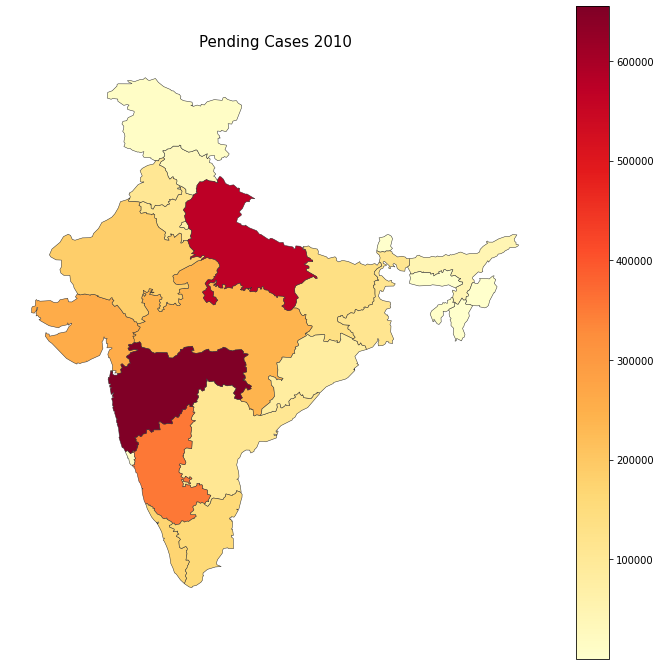

In [17]:
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.axis('off')
ax.set_title('Pending Cases 2010',fontdict={'fontsize': '15', 'fontweight' : '3'})
fig = pendingMap.plot(column='Pending Cases', cmap='YlOrRd', linewidth=0.5, ax=ax, edgecolor='0.2',legend=True)
plt.savefig('pendingCases2010.png')